In [147]:
import tarfile
import re
from datetime import datetime
from collections import namedtuple, Counter

import pandas as pd
import altair as alt

In [4]:
tar = tarfile.open("../012 Use regular expressions to identify potentially sensitive data/enron_mail_20150507.tar.gz", "r")

In [5]:
items = tar.getmembers()

In [50]:
Email = namedtuple('Email', 'Date, From, To, Subject, Cc, Bcc, Message')

In [110]:
# figure out structure of each file

def get_msg(item_number):
    f = tar.extractfile(items[item_number])

    try:
        date = from_ = to = subject = cc = bcc = message= ''
        in_to = False
        in_message = False
        to = []
        message = []
        item = f.read().decode()
        item = item.replace('\r', '').replace('\t', '')
        lines = item.split('\n')
        # print(len(lines))

        for num, line in enumerate(lines):
            if line.startswith('Date:') and not date:
                date = datetime.strptime(' '.join(line.split('Date: ')[1].split()[:-2]), '%a, %d %b %Y %H:%M:%S')
            elif line.startswith('From:') and not from_:
                from_ = line.replace('From:', '').strip()
            elif line.startswith('To:') and not to:
                in_to = True
                to = line.replace('To:', '').replace(',', '').replace(';', '').split()
            elif line.startswith('Subject:') and not subject:
                in_to = False
                subject = line.replace('Subject:', '').strip()
            elif line.startswith('Cc:') and not cc:
                cc = line.replace('Cc:', '').replace(',', '').replace(';', '').split()
            elif line.startswith('Bcc:') and not bcc:
                bcc = line.replace('Bcc:', '').replace(',', '').replace(';', '').split()
            elif in_to:
                to.extend(line.replace(',', '').split())
            elif line.startswith('Subject:') and not subject:
                in_to = False
            elif line.startswith('X-FileName'):
                in_message = True
            elif in_message:
                message.append(line)

        to = '; '.join(to).strip()
        cc = '; '.join(cc).strip()
        bcc = '; '.join(bcc).strip()
        message = ' '.join(message).strip()
        email = Email(date, from_, to, subject, cc, bcc, message)
        return email

    except Exception as e:
        return e

In [253]:
msg = get_msg(3002)

In [258]:
msg.Message

"Tom, 1:30 until 3:30 should be ample time to cover the Timeline and answer any questions the group has.  John Buchanan   -----Original Message----- From: Halpin, Tom   Sent:Friday, October 19, 2001 7:55 AM To:Buchanan, John Subject:RE: Follow up on the Nomination/Confirmation Process  John, that sounds good.  The feedback I have received indicates the 29th is the better date.  Please let me know when your schedule is finalized and I will get out a note to the folks here.  How much time do you think you need?  Would 130-330 or so work?  Thanks again, Tom.   -----Original Message----- From: Buchanan, John   Sent:Friday, October 19, 2001 5:52 AM To:Halpin, Tom Cc:Blair, Lynn; Garcia, Ava Subject:RE: Follow up on the Nomination/Confirmation Process  Tom, Lynn is in California until next Wednesday October 24th so I need to arrange the flights for this trip. So far it looks like either day is good for the meeting on Nominations and Scheduling so I will arrange for Lynn and I to come to Omah

In [251]:
len(items)

520901

In [200]:
dates = []

for num in range(len(items)):
    msg = get_msg(num)
    if not isinstance(msg, tuple):
        continue
    dates.append(msg.Date)

In [201]:
dates_count = Counter(dates)

In [214]:
df = pd.DataFrame.from_dict(dates_count, orient='index').reset_index()
df.columns = ['datetime', 'count']

In [217]:
df['date'] = df['datetime'].map(lambda x: x.date())

In [218]:
df.head()

,datetime,count,date
0,2001-09-14 14:05:43,1,2001-09-14
1,2001-09-10 10:33:15,1,2001-09-10
2,2001-08-20 12:34:19,1,2001-08-20
3,2001-07-05 08:35:29,2,2001-07-05
4,2001-07-26 08:16:14,1,2001-07-26


In [241]:
pivot = df.pivot_table(index='date', values='count', aggfunc='sum').reset_index()
pivot = pivot[(pivot['date'] > pd.datetime(2000, 1, 1).date()) & (pivot['date'] < pd.datetime(2002, 6, 30).date())]
pivot['date'] = pd.to_datetime(pivot['date'])

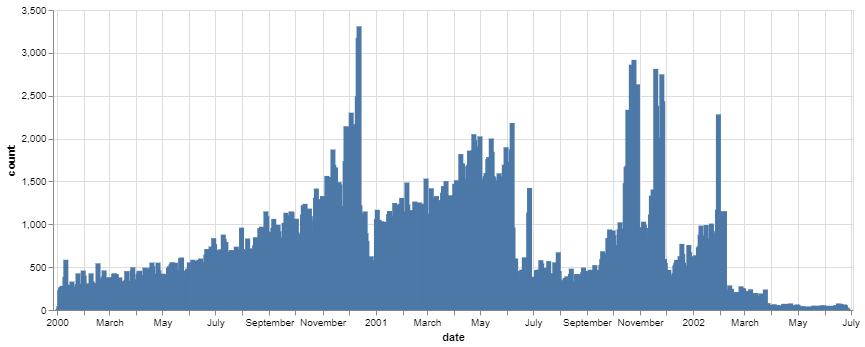

In [242]:
alt.Chart(pivot).mark_bar().encode(
    x='date',
    y='count',
    tooltip=['date', 'count'],
).properties(width=800)